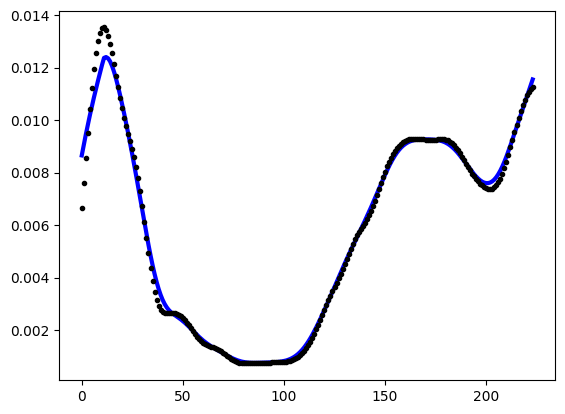

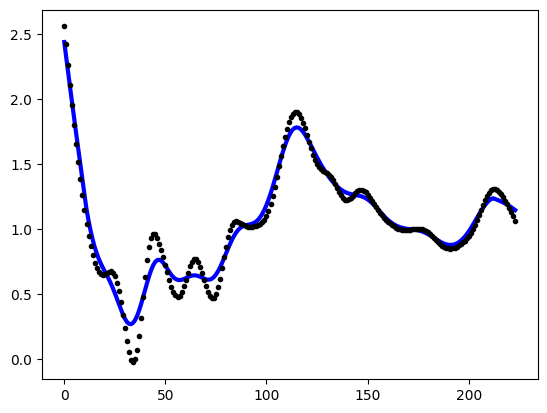

<ipython-input-2-5f0c4e07d2d2>:103: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(t, S, 'k', alpha=1, lw=2, label='Fit', color='darkred')
<ipython-input-2-5f0c4e07d2d2>:115: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax1.plot(t, I, 'k', alpha=1, lw=2, label='Fit', color='darkred')
<ipython-input-2-5f0c4e07d2d2>:127: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax2.plot(t, Rt, 'k', alpha=1, lw=2, label='Fit', color='darkred')


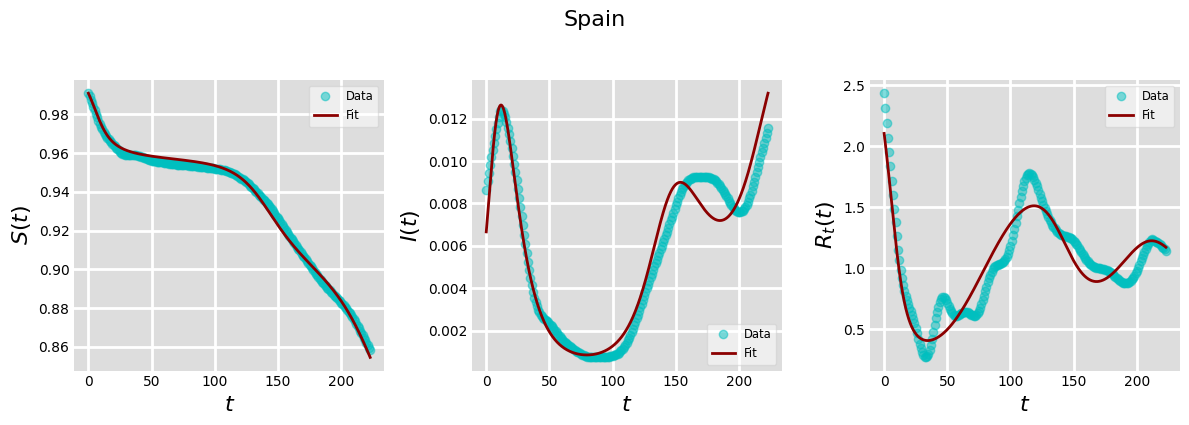

<ipython-input-2-5f0c4e07d2d2>:171: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(I, Rt, 'k-', alpha=1, lw=2, label='Fit', zorder=9, color='darkred')
<ipython-input-2-5f0c4e07d2d2>:186: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax1.plot(S, Rt, 'k-', alpha=1, lw=2, label='Fit', zorder=9, color='darkred')
<ipython-input-2-5f0c4e07d2d2>:200: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax2.plot(S, I, 'k-', alpha=1, lw=2, label='Fit', zorder=9, color='darkred')


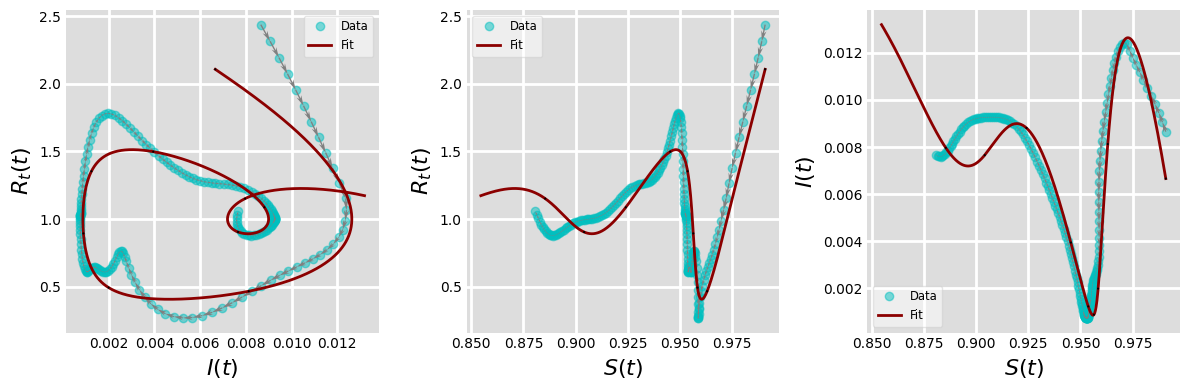

In [2]:
!pip install -q sdeint
import sdeint
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
!pip install -q lmfit
import lmfit
from lmfit import Parameters, Minimizer, report_fit
!pip install -q numdifftools
import numdifftools
import pickle
from zipfile import ZipFile
!pip install -q tsmoothie
from tsmoothie.smoother import LowessSmoother

#####################################
#   Modelo SIR Polleti Gamma fixo   #
#####################################

name = 'Spain'
name1 = 'Spain'

S_data = pd.read_table(name+'_S.csv', header=None)
I_data = pd.read_table(name+'_I10.csv', header=None)
R_data = pd.read_table(name+'_R.csv', header=None)

N = 230

S_data = S_data[0][0:N]
I_data = I_data[0][0:N]
R_data = R_data[0][0:N]

gamma = 0.1

Rt_data = []
Rt_data.append(1+(I_data[1]-I_data[0])/(gamma*I_data[0]))
for i in range(0,len(I_data)-1):
  Rt_data.append(1+(I_data[i+1]-I_data[i])/(gamma*I_data[i]))
Rt_data = pd.DataFrame(Rt_data).rolling(7,center=True, min_periods=7).mean().dropna()[0].to_numpy(dtype='float')

S_data = S_data[3:N-3]
I_data = I_data[3:N-3]
R_data = R_data[3:N-3]

t0 = np.array(range(len(S_data)))
t = np.linspace(0, int(1*len(S_data))-1, 100*N)

# The SIRD model differential equations.
def deriv(y, t, beta_n, beta_a, gamma, k0, k1, k2, k3, delta):
    S, I, Rt = y
    dSdt = -gamma*Rt*I
    dIdt = gamma*(Rt-1)*I
    dRtdt = -(beta_n + (beta_n*beta_a))*I*Rt - beta_n*(beta_n*beta_a)*S*I/gamma + delta*(k0 -k1*I -k2*Rt + k3*S)*(gamma*Rt - (beta_n*beta_a)*S)*(-gamma*Rt + beta_n*S)/(gamma*(beta_n-(beta_n*beta_a)))
    return dSdt, dIdt, dRtdt

# Initial conditions vector
y0 = S_data[3], I_data[3], Rt_data[3]

# Data to be fited
data2 = []
data2.append(S_data)
data2.append(I_data)
data2.append(Rt_data)
data2 = np.array(data2)

k0 = 1.044
k1 = 10.973
k2 = 0.0282
k3 = -1.0187
beta_n = 0.3501
beta_a = 0.0248
delta = 1

ret = odeint(deriv, y0, t, args=(beta_n, beta_a, gamma, k0, k1, k2, k3, delta))
S, I, Rt = ret.T

smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)
smoother.smooth(I_data)

# plot the smoothed timeseries with intervals
plt.figure()
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
plt.plot(smoother.data[0], '.k')
plt.show()

I_data = smoother.smooth_data[0]

smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)
smoother.smooth(Rt_data)

# plot the smoothed timeseries with intervals
plt.figure()
plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
plt.plot(smoother.data[0], '.k')
plt.show()

Rt_data = smoother.smooth_data[0]

fig = plt.figure(facecolor='w',figsize=(12,4))
ax = fig.add_subplot(131, facecolor='#dddddd', axisbelow=True)
ax.plot(t0, S_data, 'co', alpha=0.5, label='Data')
ax.plot(t, S, 'k', alpha=1, lw=2, label='Fit', color='darkred')
ax.set_xlabel(r'$\it{t}$', fontsize=16)
ax.set_ylabel(r'$\it{S(t)}$', fontsize=16)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(which='major', c='w', lw=2, ls='-')
legend = ax.legend(fontsize='small')
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
ax1 = fig.add_subplot(132, facecolor='#dddddd', axisbelow=True)
ax1.plot(t0, I_data, 'co', alpha=0.5, label='Data')
ax1.plot(t, I, 'k', alpha=1, lw=2, label='Fit', color='darkred')
ax1.set_xlabel(r'$\it{t}$', fontsize=16)
ax1.set_ylabel(r'$\it{I(t)}$', fontsize=16)
ax1.yaxis.set_tick_params(length=0)
ax1.xaxis.set_tick_params(length=0)
ax1.grid(which='major', c='w', lw=2, ls='-')
legend = ax1.legend(fontsize='small')
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax1.spines[spine].set_visible(False)
ax2 = fig.add_subplot(133, facecolor='#dddddd', axisbelow=True)
ax2.plot(t0, Rt_data, 'co', alpha=0.5, label='Data')
ax2.plot(t, Rt, 'k', alpha=1, lw=2, label='Fit', color='darkred')
ax2.set_xlabel(r'$\it{t}$', fontsize=16)
ax2.set_ylabel(r'$\it{R_t(t)}$', fontsize=16)
ax2.yaxis.set_tick_params(length=0)
ax2.xaxis.set_tick_params(length=0)
ax2.grid(which='major', c='w', lw=2, ls='-')
legend = ax2.legend(fontsize='small')
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax2.spines[spine].set_visible(False)
suptitle = plt.suptitle(name1, fontsize=16, y=1.05)
plt.tight_layout()
plt.savefig('upper_panel_'+name+'.png', format='png', dpi=600, bbox_extra_artists=(suptitle,), bbox_inches="tight")
ax.set_rasterized(True)
ax1.set_rasterized(True)
ax2.set_rasterized(True)
plt.savefig('upper_panel_'+name+'.eps', format='eps', bbox_extra_artists=(suptitle,), bbox_inches="tight")
plt.show()

N2 = 1

N3 = 20

U = np.asarray(I_data[1:-N3])-np.asarray(I_data[:-1-N3])
V = np.asarray(Rt_data[1:-N3])-np.asarray(Rt_data[:-1-N3])
W = np.asarray(S_data[1:-N3])-np.asarray(S_data[:-1-N3])


N1 = 5

arrows = int(len(I)/N1)

N_arrows = 9

U1 = np.asarray(I[1+N1::N1])-np.asarray(I[:-1-N1:N1])
V1 = np.asarray(Rt[1+N1::N1])-np.asarray(Rt[:-1-N1:N1])
W1 = np.asarray(S[1+N1::N1])-np.asarray(S[:-1-N1:N1])

#U1 = .05*U1 / np.sqrt(U1**2 + V1**2)
#V1 = .05*V1 / np.sqrt(U1**2 + V1**2)

fig = plt.figure(facecolor='w',figsize=(12,4))
ax = fig.add_subplot(131, facecolor='#dddddd', axisbelow=True)
ax.plot(I_data[:-N3], Rt_data[:-N3], 'co', alpha=0.5, lw=2, label='Data')
ax.plot(I, Rt, 'k-', alpha=1, lw=2, label='Fit', zorder=9, color='darkred')
ax.quiver(I_data[:-1-N3], Rt_data[:-1-N3], U, V, angles='xy', scale_units='xy', scale=1, headwidth=4, headlength=8, headaxislength=6, color='gray', zorder=8)
ax.quiver(I[:-1-N1:int(arrows/N_arrows)*N1], Rt[:-1-N1:int(arrows/N_arrows)*N1], U1[::int(arrows/N_arrows)], V1[::int(arrows/N_arrows)], angles='xy', scale_units='xy', scale=1, headwidth=4, headlength=8, headaxislength=6, zorder=10)
#ax.quiver(I[int(arrows/N_arrows)*N1:-1-N1:int(arrows/N_arrows)*N1], Rt[int(arrows/N_arrows)*N1:-1-N1:int(arrows/N_arrows)*N1], U1[int(arrows/N_arrows)::int(arrows/N_arrows)], V1[int(arrows/N_arrows)::int(arrows/N_arrows)], angles='xy', scale_units='xy', scale=1, headwidth=4, headlength=8, headaxislength=6, zorder=10)
ax.set_xlabel(r'$\it{I(t)}$', fontsize=16)
ax.set_ylabel(r'$\it{R_t(t)}$', fontsize=16)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(which='major', c='w', lw=2, ls='-')
legend = ax.legend(fontsize='small')
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
ax1 = fig.add_subplot(132, facecolor='#dddddd', axisbelow=True)
ax1.plot(S_data[:-N3], Rt_data[:-N3], 'co', alpha=0.5, lw=2, label='Data')
ax1.plot(S, Rt, 'k-', alpha=1, lw=2, label='Fit', zorder=9, color='darkred')
ax1.quiver(S_data[:-1-N3], Rt_data[:-1-N3], W, V, angles='xy', scale_units='xy', scale=1, headwidth=4, headlength=8, headaxislength=6, color='gray', zorder=8)
ax1.quiver(S[:-1-N1:int(arrows/N_arrows)*N1], Rt[:-1-N1:int(arrows/N_arrows)*N1], W1[::int(arrows/N_arrows)], V1[::int(arrows/N_arrows)], angles='xy', scale_units='xy', scale=1, headwidth=4, headlength=8, headaxislength=6, zorder=10)
ax1.set_xlabel(r'$\it{S(t)}$', fontsize=16)
ax1.set_ylabel(r'$\it{R_t(t)}$', fontsize=16)
ax1.yaxis.set_tick_params(length=0)
ax1.xaxis.set_tick_params(length=0)
ax1.grid(which='major', c='w', lw=2, ls='-')
legend = ax1.legend(fontsize='small')
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax1.spines[spine].set_visible(False)
ax2 = fig.add_subplot(133, facecolor='#dddddd', axisbelow=True)
ax2.plot(S_data[:-N3], I_data[:-N3], 'co', alpha=0.5, lw=2, label='Data')
ax2.plot(S, I, 'k-', alpha=1, lw=2, label='Fit', zorder=9, color='darkred')
ax2.quiver(S_data[:-1-N3], I_data[:-1-N3], W, U, angles='xy', scale_units='xy', scale=1, headwidth=4, headlength=8, headaxislength=6, color='gray', zorder=8)
ax2.quiver(S[:-1-N1:int(arrows/N_arrows)*N1], I[:-1-N1:int(arrows/N_arrows)*N1], W1[::int(arrows/N_arrows)], U1[::int(arrows/N_arrows)], angles='xy', scale_units='xy', scale=1, headwidth=4, headlength=8, headaxislength=6, zorder=10)
ax2.set_xlabel(r'$\it{S(t)}$', fontsize=16)
ax2.set_ylabel(r'$\it{I(t)}$', fontsize=16)
ax2.yaxis.set_tick_params(length=0)
ax2.xaxis.set_tick_params(length=0)
ax2.grid(which='major', c='w', lw=2, ls='-')
legend = ax2.legend(fontsize='small')
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax2.spines[spine].set_visible(False)
plt.tight_layout()
plt.savefig('Risk_Diagrams_'+name+'.png', format='png', dpi=600)
ax.set_rasterized(True)
ax1.set_rasterized(True)
ax2.set_rasterized(True)
plt.savefig('Risk_Diagrams_'+name+'.eps', format='eps')
plt.show()